In [1]:
import sys
sys.path.append("/Users/haas/Documents/Masters/GANQS/src/")
from nqs import nqs, pretrain
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

### System

In [2]:
nparticles = 2
dim = 2
seed = 42
mcmc_alg = "m" 
training_cycles = 100 
batch_size = 10000


### Generator


In [3]:
gen_system = nqs.NQS(
    nqs_repr="psi",
    backend="jax",
    log=True,
    logger_level="INFO",
    seed=seed,
)

gen_system.set_wf(
    "ffnn",
    nparticles,
    dim,  # all after this is kwargs.
    layer_sizes=[
        nparticles * dim,  # should always be this
        7,
        5,
        3,
        1,  # should always be this
    ],
    activations=["gelu", "gelu", "gelu", "linear"],
    symmetry="none",
)

gen_system.set_sampler(mcmc_alg=mcmc_alg, scale=1)
gen_system.set_hamiltonian(
    type_="ho", int_type="Coulomb", omega=1.0, r0_reg=1, training_cycles=training_cycles
)

INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.


In [4]:
### generate untrained sample
state = gen_system.wf.state
states = state.create_batch_of_states(batch_size=batch_size)
sample = gen_system._sampler.step(
    gen_system.wf, states, seed, batch_size=batch_size
)

sample.positions.shape

(10000, 4)

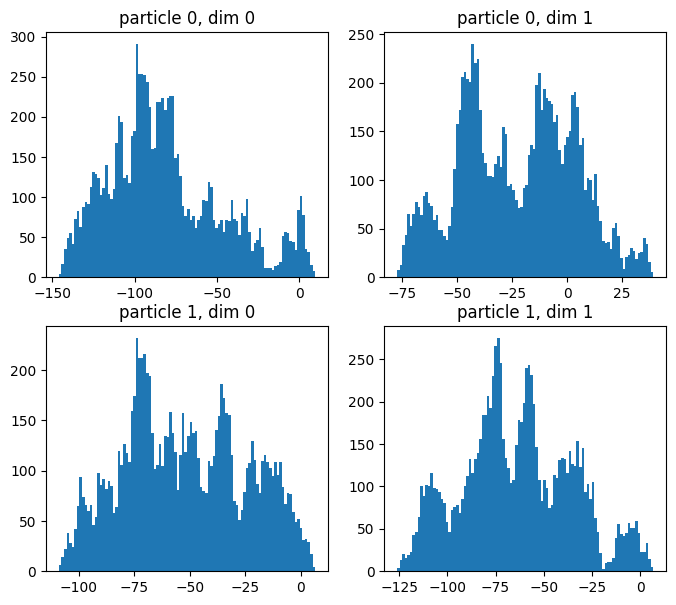

In [5]:
fig, ax = plt.subplots(nparticles, dim, figsize=(8, 7))
for i in range(nparticles):
    for j in range(dim):
        ax[i, j].hist(sample.positions[:, i*dim + j], bins=100)
        ax[i, j].set_title(f"particle {i}, dim {j}")

### Truth

In [6]:
truth_system = pretrain.Gaussian(log=True, logger_level="INFO", seed=seed, symmetry="boson")
truth_system._N = nparticles # should be done properly later
truth_system._dim = dim # should be done properly later
truth = np.random.normal(size=(batch_size, nparticles*dim));
truth.shape

(10000, 4)

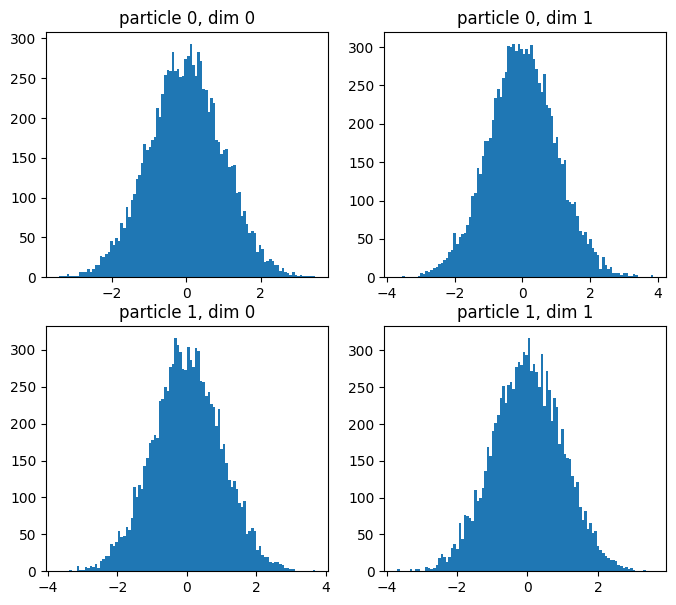

In [7]:
#plot histogram of the truth in each dimension for each particle

fig, axs = plt.subplots(nparticles, dim, figsize=(8, 7))
for i in range(nparticles):
    for j in range(dim):
        axs[i, j].hist(truth[:, i*dim + j], bins=100)
        axs[i, j].set_title(f"particle {i}, dim {j}")


### Discriminator

In [8]:
disc_system = nqs.NQS(
    nqs_repr="psi",
    backend="jax",
    log=True,
    logger_level="INFO",
    seed=seed,
)

disc_system.set_wf( # NOT A WF THIS TIME BUT ANYWAYS...
    "ffnn",
    nparticles,
    dim,  # all after this is kwargs.
    layer_sizes=[
        nparticles * dim,  # should always be this
        7,
        5,
        3,
        1,  # should always be this
    ],
    activations=["relu", "relu", "relu", "sigmoid"],
)

disc_system.set_optimizer("adam", eta=0.01)

INFO:NQS      Neural Network Quantum State initialized with symmetry None as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with symmetry None as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.


In [9]:
# generate train data (concatenate training and generated samples with a flag)
train_data = jnp.concatenate((truth, sample.positions), axis=0)
train_labels = jnp.concatenate((jnp.ones(batch_size), jnp.zeros(batch_size))) # 1 for truth, 0 for generated

#shuffle data
idx = np.arange(2*batch_size)
np.random.shuffle(idx)
train_data = train_data[idx]
train_labels = train_labels[idx]


In [10]:
def predict_probas(disc_system, data, params):
    """
    should output batchsize of probas
    """
    # soft classification
    return disc_system.wf(data, params)

def log_loss(y_true, batch, params):
    """
    y_true: array of true labels
    y_pred: array of predicted labels
    """
    
    y_pred = predict_probas(disc_system, batch, params)
    return -jnp.mean(y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred)) # average over batch


## Part1: Can disc learn alone to differentiate horrible samples from a gaussian?

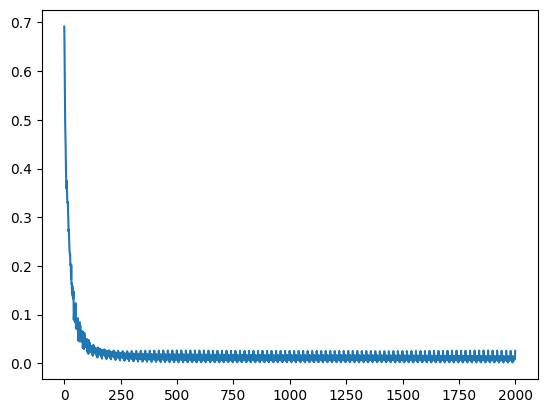

In [11]:
epochs = 100
training_batch_size = 500 # will divide train data in batches of this size
losses = []
for epoch in range(epochs):
    
    for i in range(0, 2*batch_size, training_batch_size):
        batch = train_data[i:i+training_batch_size]

        reality = train_labels[i:i+training_batch_size]
        params = disc_system.wf.params
        loss_func = log_loss

        loss = loss_func(reality, batch, params)
        losses.append(loss)
        
        grad_loss_fn = jax.grad(loss_func, argnums=2)
        grad_loss_dict = grad_loss_fn(reality, batch, params)
        
        disc_system._optimizer.step(disc_system.wf.params, grad_loss_dict, None)

plt.plot(losses)


In [12]:
# generate test samples

truth_test = np.random.normal(size=(batch_size, nparticles*dim)); # more data
sample_test = gen_system._sampler.step(
    gen_system.wf, sample, seed, batch_size=batch_size # see we start from sample, so they are deffo not the same but correlated if not in equilibrium
)

# concat both with the flags
test_data = jnp.concatenate((truth_test, sample_test.positions), axis=0)
test_labels = jnp.concatenate((jnp.ones(batch_size), jnp.zeros(batch_size))) # 1 for truth, 0 for generated

#shuffle data
idx = np.arange(2*batch_size)
np.random.shuffle(idx)
test_data = test_data[idx]
test_labels = test_labels[idx]

# predict on test data
preds = predict_probas(disc_system, test_data, disc_system.wf.params)

# compute accuracy
accuracy = np.mean((preds > 0.5) == test_labels)

print(f"Accuracy: {accuracy}")



Accuracy: 0.9996500015258789


### It seems to work. Next step is to see if after training, the discriminator still is capable of seeing the diffs
#### If the discriminator is still able to, then we can go to the next step: compute a loss that involves both gen and disc

## Part 2: train the (non interacting) generator and without symmetry.

### then plot some samples

In [13]:
gen_system = nqs.NQS( # reinitialize the generator
    nqs_repr="psi",
    backend="jax",
    log=True,
    logger_level="INFO",
    seed=seed,
)

gen_system.set_wf(
    "ffnn",
    nparticles,
    dim,  # all after this is kwargs.
    layer_sizes=[
        nparticles * dim,  # should always be this
        7,
        5,
        3,
        1,  # should always be this
    ],
    activations=["gelu", "gelu", "gelu", "linear"],
    symmetry="none",
)

gen_system.set_sampler(mcmc_alg=mcmc_alg, scale=1)
gen_system.set_hamiltonian(
    type_="ho", int_type=None, omega=1.0, r0_reg=1, training_cycles=training_cycles # let us start without interaction!
)

gen_system.set_optimizer(
    optimizer="sr",
    eta=0.1,
    gamma=0,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
)

history = gen_system.train(
    max_iter=training_cycles,
    batch_size=batch_size,
    early_stop=False,
    seed=seed,
    history=True,
    tune=False,
    grad_clip=0,
)

epochs = np.arange(len(history["energy"]))
for key, value in history.items():
    plt.plot(epochs, value, label=key)
    plt.legend()
    plt.show()

INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1

[Training progress]:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 